![](header.jpg)

# Image Compression Methods for Data Serialization

Kevin J. Walchko, Phd

10 June 2020

---

BLUF: The OpenCV JPEG compression has a high default lossy value. Compressed images create large number of artifacts but result in very small file size. However, for image processing and computer vision, the preference is to use compression but retain the original pixel values. Prefer using a lossless format like PNG where data size is reduced 40% but no differnces between original image and image after uncompression.

There is the possibility of changing JPEG compression parameters to reduce this issue, but prefer an out-of-the-box solution.

## Overview

Sending data between computer processes needs an efficient method of serialization. Images are typically very large and sending raw bytes can reduce bandwdith. Ideally we want to reduce the amount of data that needs to be sent, but ensure we can recover all of it back. JPEG is a common format to compress images, but it is a lossy format and information (maybe important information) will be lost. Other formats like JPEG2000 and PNG have the ability for large compression, but are lossless formats, so you do not loose data. This is just a quick test to see what compression ratios and data losses occur using the OpenCV compression libraries.

In [1]:
from matplotlib import pyplot as plt 
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)      

In [12]:
import cv2
import numpy as np
import time
from collections import namedtuple
import attr

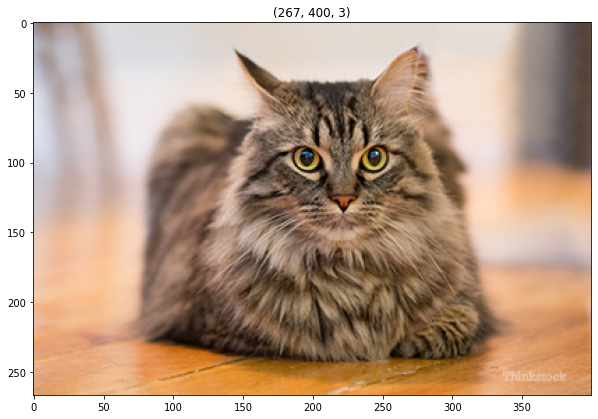

In [3]:
img = cv2.imread("cat.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title("{}".format(img.shape));

In [31]:
# class image_st(namedtuple('image_st', 'shape bytes compressed timestamp')):
#     """
#     This is the message passed from process to process.
#     shape: (rows, cols, planes)
#     bytes: array of bytes that are or aren't compressed
#     compressed: are the bytes compressed? True/False
#     timestamp: unix timestamp
#     """
#     __slots__ = ()

#     def __new__(cls, s, b, c, ts=None):
# #         cls.id = GeckoMsgFlags.image

#         if ts:
#             return cls.__bases__[0].__new__(cls, s, b, c, ts)
#         else:
#             return cls.__bases__[0].__new__(cls, s, b, c, time.time())
        
#     def uncompress(self):
#         img = np.frombuffer(self.bytes, dtype=np.uint8)
        
#         if self.compressed:
#             if len(self.shape) == 3:
#                 img = cv2.imdecode(img, cv2.IMREAD_COLOR)
#             else:
#                 img = cv2.imdecode(img, cv2.IMREAD_GRAYSCALE)
            
#         img = img.reshape(self.shape)
#         return img

@attr.s(slots=True)
class image_st:
    """
    This is the message passed from process to process.
    shape: (rows, cols, planes)
    bytes: array of bytes that are or aren't compressed
    compressed: are the bytes compressed? True/False
    timestamp: unix timestamp
    """
    shape = attr.ib()
    bytes = attr.ib()
    compressed = attr.ib(default=False)
    timestamp = attr.ib(default=time.time())
    
    def uncompress(self):
        img = np.frombuffer(self.bytes, dtype=np.uint8)

        if self.compressed:
            if len(self.shape) == 3:
                img = cv2.imdecode(img, cv2.IMREAD_COLOR)
            else:
                img = cv2.imdecode(img, cv2.IMREAD_GRAYSCALE)

        img = img.reshape(self.shape)
        return img
    
    def __str__(self):
        if self.compressed:
            s = f"CompressedImage{self.shape} {self.timestamp}"
        else:
            s = f"Image{self.shape} {self.timestamp}"
        return s

    

def serialize_image(img, compression=None):
    """
    Helper function to create a message from an image and optionally use compression.
    """
    if compression:
        compressed = True
        data = cv2.imencode(compression, img)[1]
    else:
        compressed = False
        data = img.tobytes()

    return image_st(img.shape, data, compressed)

# Color Images

## Uncompressed

In [32]:
im = serialize_image(img)
print(im)

Image(267, 400, 3) 1591835367.812872


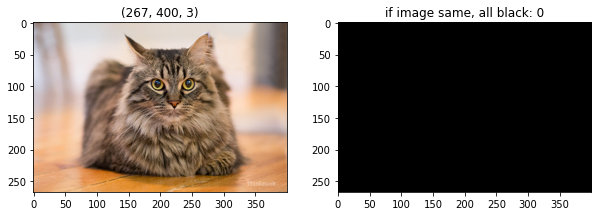

In [20]:
bimg = im.uncompress()
plt.subplot(1,2,1)
plt.imshow(bimg)
plt.title("{}".format(bimg.shape));
plt.subplot(1,2,2)
plt.imshow(img - bimg)
plt.title("if image same, all black: {}".format((img - bimg).sum()));

## JPEG

In [21]:
imc = Image_st(img, '.jpg')

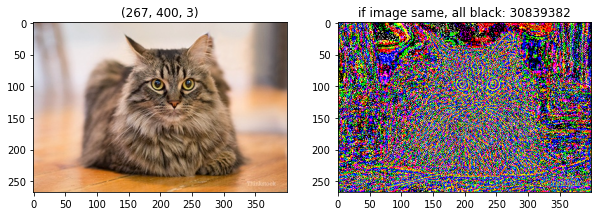

In [22]:
bimgc = imc.uncompress()

plt.subplot(1,2,1)
plt.imshow(bimgc)
plt.title("{}".format(bimgc.shape));
plt.subplot(1,2,2)
plt.imshow(img - bimgc)
# div = img.shape[0]
plt.title("if image same, all black: {}".format(((img - bimgc).sum())));

In [23]:
print("uncompressed: {}".format(len(im.bytes)))
print("compressed: {}".format(len(imc.bytes)))
print("ration (comp/uncomp): {:.1f}%".format(len(imc.bytes)/len(im.bytes)*100))

uncompressed: 320400
compressed: 39480
ration (comp/uncomp): 12.3%


## PNG

In [24]:
imc = Image_st(img, '.png')

In [25]:
print("uncompressed: {}".format(len(im.bytes)))
print("compressed: {}".format(len(imc.bytes)))
print("ration (comp/uncomp): {:.1f}%".format(len(imc.bytes)/len(im.bytes)*100))

uncompressed: 320400
compressed: 190789
ration (comp/uncomp): 59.5%


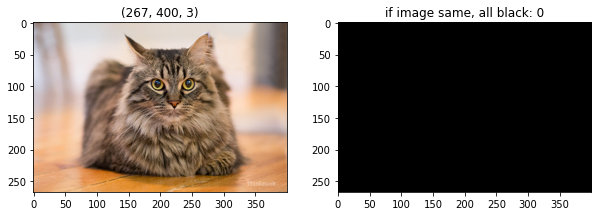

In [26]:
bimgc = imc.uncompress()

plt.subplot(1,2,1)
plt.imshow(bimgc)
plt.title("{}".format(bimgc.shape));
plt.subplot(1,2,2)
plt.imshow(img - bimgc)
# div = img.shape[0]
plt.title("if image same, all black: {}".format(((img - bimgc).sum())));

# Grayscale Images

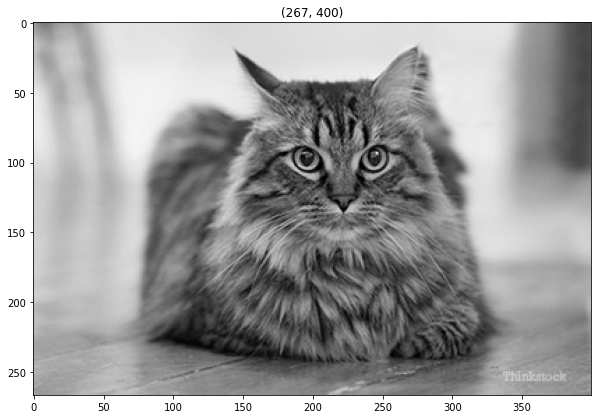

In [27]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.title("{}".format(gray.shape));

In [28]:
gr = Image_st(gray)
grc = Image_st(gray, '.png')

In [29]:
print("uncompressed: {}".format(len(gr.bytes)))
print("compressed: {}".format(len(grc.bytes)))
print("ration (comp/uncomp): {:.1f}%".format(len(grc.bytes)/len(gr.bytes)*100))

uncompressed: 106800
compressed: 64959
ration (comp/uncomp): 60.8%


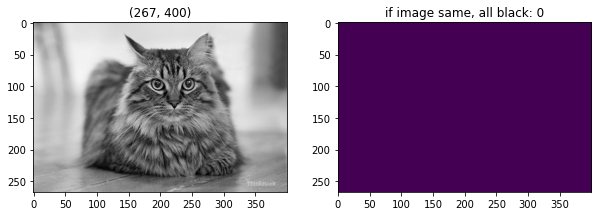

In [30]:
bgrc = grc.uncompress()

plt.subplot(1,2,1)
plt.imshow(bgrc, cmap='gray')
plt.title("{}".format(bgrc.shape));
plt.subplot(1,2,2)
plt.imshow(gray - bgrc)
# div = img.shape[0]
plt.title("if image same, all black: {}".format(((gray - bgrc).sum())));